In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, yaml

In [2]:
def load_arrs(id, data_dir):
    '''
    Retorno:
        num_active, num_created, time
    '''
    num_active = np.load(f"{data_dir}/num_active_{id}.npy")
    num_created = np.load(f"{data_dir}/num_created_{id}.npy")
    time = np.load(f"{data_dir}/time_{id}.npy")

    with open(os.path.join(data_dir, "metadata.yaml")) as f:
        metadata = yaml.unsafe_load(f)

    n = metadata["num_points"]
    return num_active[:n], num_created[:n], time[:n]

def get_conv_arr(arr, kernel_size):
    num_points = arr.size - kernel_size
    new_arr = np.zeros(num_points, dtype=arr.dtype)
    for i in range(num_points):
        new_arr[i] = arr[i:i+kernel_size].sum()
    
    # start_id = 0
    # end_id = start_id + kernel_size
    # while end_id <= arr.size:
    #     new_arr[i] = arr[i:i+kernel_size].sum()

    return new_arr

def get_mean_arr(arr, kernel_size):
    new_arr = []
    start_id = 0
    end_id = start_id + kernel_size
    while end_id <= arr.size:
        new_arr.append(arr[start_id:end_id].sum()/kernel_size)
        start_id = end_id
        end_id += kernel_size

    return np.array(new_arr)


In [79]:
from pathlib import Path
Path("data/low_adh_align/data").parents[1]


PosixPath('data')

In [103]:
data_dir = "data/low_adh_align_flux/data"

import yaml
from pathlib import Path
with open(Path(data_dir).parent / "config.yaml") as f:
    flux = yaml.unsafe_load(f)["other_cfgs"]["stokes"].flux_force

num_active, num_created, time = load_arrs(0, data_dir)

In [106]:
num_created[time > 1000].sum() / (3000-1000)

0.0825

In [100]:
kernel_time = 30
dt = 0.5

cut_id = 0

kernel_size = int(kernel_time/dt)
mean_created = get_mean_arr(num_created[cut_id:], kernel_size)/dt
mean_time = get_mean_arr(time[cut_id:], kernel_size)

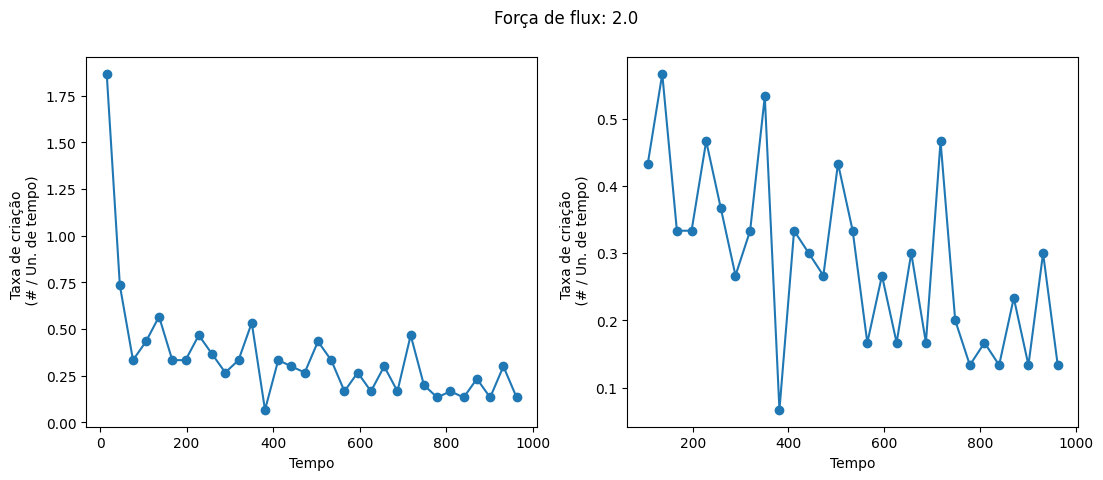

In [101]:
to_save = True
root_dir = "/home/marcos/Desktop"

mask = mean_time > 100

fig, ax = plt.subplots(1, 2)

w, h = fig.get_size_inches()
fig.set_size_inches(w*2, h)

fig.suptitle(f"Força de flux: {flux}")

ax[0].set_xlabel("Tempo")
ax[0].set_ylabel("Taxa de criação \n (# / Un. de tempo)")

ax[0].plot(mean_time, mean_created, "o-")

ax[1].set_xlabel("Tempo")
ax[1].set_ylabel("Taxa de criação \n (# / Un. de tempo)")

ax[1].plot(mean_time[mask], mean_created[mask], "o-")

if to_save:
    plt.savefig(root_dir + f"/flux_{flux}_time.png")
else:
    plt.show()

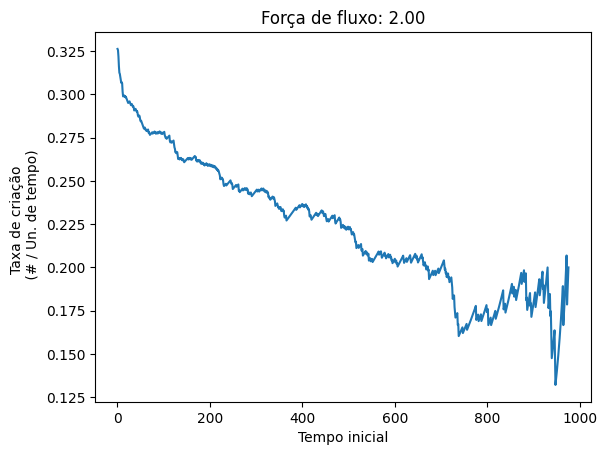

In [102]:
creation_rate_t = []
t_array = np.arange(1, time[-50])
for t in t_array:
    mask = time > t
    creation_rate_t.append(num_created[mask].sum()/(time[-1]-t))

plt.xlabel("Tempo inicial")
plt.ylabel("Taxa de criação \n (# / Un. de tempo)")
plt.title(f"Força de fluxo: {flux:.2f}")

plt.plot(t_array, creation_rate_t)

if to_save:
    plt.savefig(root_dir + f"/flux_{flux}_init_time.png")
else:
    plt.show()

In [107]:
data_dir = "data/low_adh_align"
img_dir = "data/images/low_adh_align"

kernel_time = 50

dt = 0.01
kernel_size = int(kernel_time/dt)

create_rate_arr = []
mean_std = {
    "active": ([], []),
    "created": ([], []),
}

flux_range = np.load(f"{data_dir}/flux.npy")
# for id in range(flux_range.size):
for id in range(flux_range.size):
    num_active, num_created, time = load_arrs(id, data_dir)
    
    values = {
        "active": num_active,
        # "created": get_conv_arr(num_created, kernel_size)/kernel_time,
        "created": get_mean_arr(num_created, kernel_size)/dt,
    }
    for name in mean_std.keys():
        mean_std[name][0].append(values[name].mean())
        mean_std[name][1].append(values[name].std())

    rate = num_created.sum()/(time[-1] - time[0])
    create_rate_arr.append(rate)    

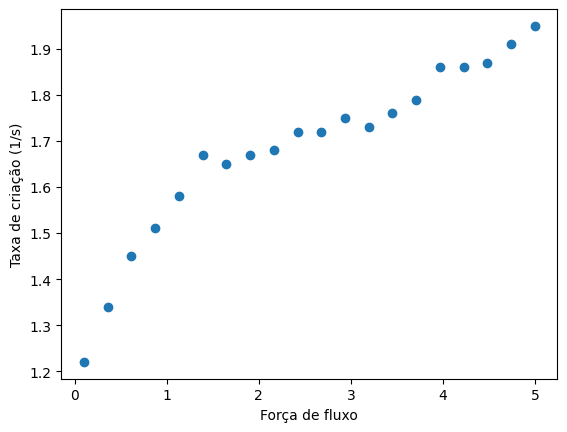

In [108]:
plt.scatter(flux_range, create_rate_arr)

plt.xlabel("Força de fluxo")
plt.ylabel("Taxa de criação (1/s)")

plt.savefig(os.path.join(img_dir, "creation_rate.png"))

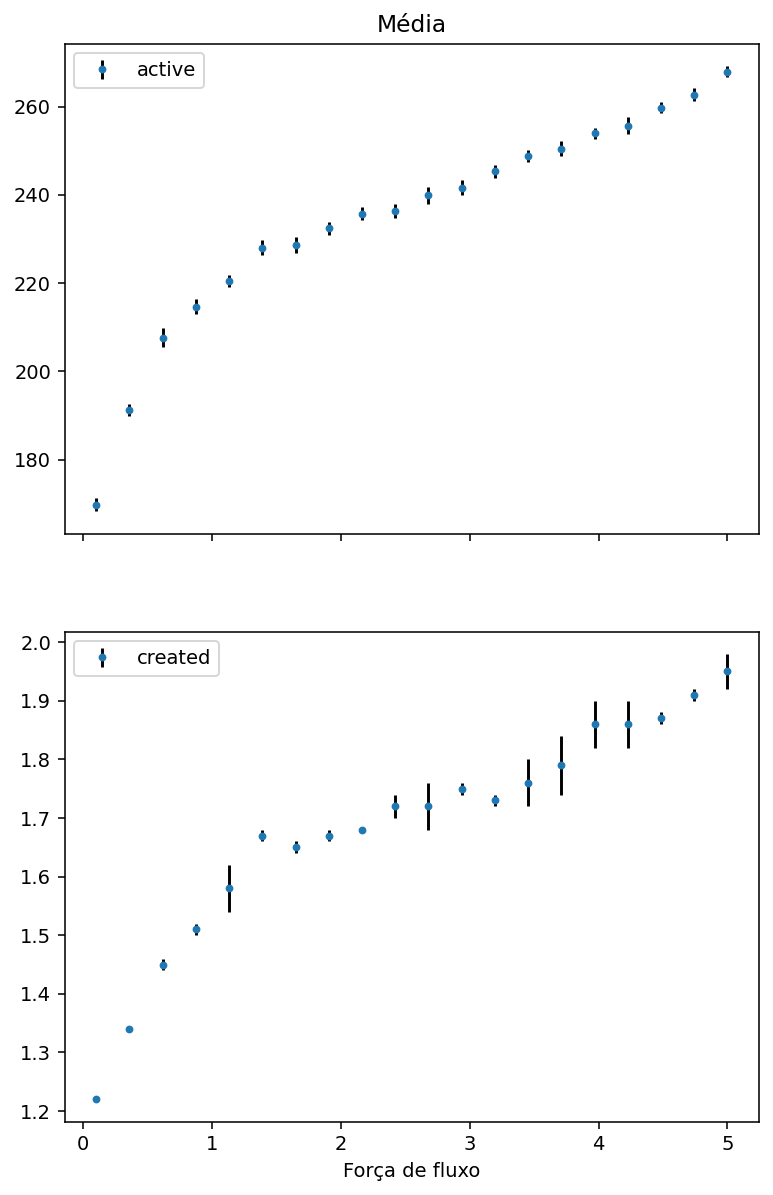

In [109]:
fig, ax = plt.subplots(2, sharex=True)
fig.set_dpi(140)
fig.set_figheight(10)


name = "active"
ax[0].errorbar(flux_range, mean_std[name][0], mean_std[name][1], fmt=".", ecolor="black", label=name)

name = "created"
ax[1].errorbar(flux_range, mean_std[name][0], mean_std[name][1], fmt=".", ecolor="black", label=name)

ax[0].set_title("Média")


for i in range(2):
    ax[i].legend()

ax[1].set_xlabel("Força de fluxo")

ax[0].set_ylabel("Nº de anéis")
ax[1].set_ylabel("Taxa de criação (Por unidade de tempo)")

fig.savefig(os.path.join(img_dir, "creation_rate2.png"))

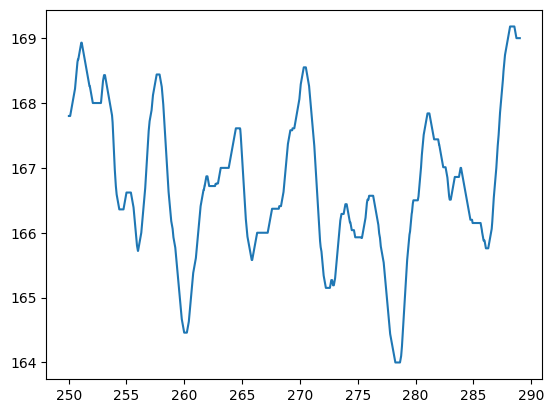

In [63]:
num_active, num_created, time = load_arrs(0, "data/data1")

dt =0.01
t=1
ks = int(t/dt)

mean_created = get_conv_arr(num_active, ks)/ks

plt.plot(time[:mean_created.size], mean_created)

# plt.hist(get_mean_arr(num_created, int(t/dt)), bins=20)
# plt.figure()
# plt.hist(num_active, bins=20)